In [147]:
import obspy
import h5py
from scipy.signal import spectrogram
import numpy as np
import glob
import matplotlib. pyplot as plt
import matplotlib.dates as mdates
import datetime as datetime
import multiprocessing
from multiprocessing import set_start_method
from compute_spectrogram import (compute_spectrogram, plot_spectrogram, compute_and_plot_spectrogram,
                                compute_and_save_spectrogram)

In [ ]:
'''

Set spectrogram parameters

'''

window_length = 1000 # seconds
noverlap = 0.75 # ratio of window_length

In [ ]:
# get list of all continuous channel files
path = "/1-fnp/pnwstore1/p-wd05/greenland/data/channel/"
files = glob.glob(path+"*")

# list any already-processed files
# out_path = "/fd1/solinger/spectrograms/"
# out_files = glob.glob(out_path+"*")
# for out_f in out_files:
#     for i,f in enumerate(files):
#         if out_f.split("/")[4].split(".")[0] in f:
#             del files[i]

# sort by channel
channels = list(map(int,[f.split("_")[1].split(".")[0] for f in files]))
sort_idx = np.argsort(channels)
files = np.array(files)[sort_idx]
channels = np.array(channels)[sort_idx]

In [ ]:
'''

Plot spectrogram for each channel

'''

# set output path
out_path = "/store_ssd4/greenland/spectrograms/"

# construct iterable list of detection parameter objects for starmap
inputs = []
for f in files:
    input_val = [f,window_length,noverlap,out_path]
    inputs.append(input_val)

# start parallel pool
nprocs = 4
multiprocessing.freeze_support()
if __name__ == '__main__':
    p = multiprocessing.Pool(processes=nprocs)
    with p multiprocessing.Pool(processes=nprocs) as p
        p.starmap(compute_and_save_spectrogram,inputs):
    p.close()
    p.join()

In [ ]:
# get list of all continuous channel files
path = "/1-fnp/pnwstore1/p-wd05/greenland/data/channel/"
files = glob.glob(path+"/*")

# list any already-processed files
out_path = "/1-fnp/pnwstore1/p-wd05/greenland/spectrograms/"
out_files = glob.glob(out_path+"*h5")
for out_f in out_files:
    for i,f in enumerate(files):
        if out_f.split("/")[6].split(".")[0] in f:
            del files[i]

# sort by channel
channels = list(map(int,[f.split("_")[1].split(".")[0] for f in files]))
sort_idx = np.argsort(channels)
files = np.array(files)[sort_idx]
channels = np.array(channels)[sort_idx]

In [ ]:
'''

Get spectrogram data for each channel (parallel)

'''

# set output path
out_path = "/store_ssd4/greenland/spectrograms/"

# construct iterable list of detection parameter objects for starmap
inputs = []
for f in files:
    input_val = [f,window_length,noverlap,out_path]
    inputs.append(input_val)

# start parallel pool
nprocs = 24
multiprocessing.freeze_support()
if __name__ == '__main__':
    with p multiprocessing.Pool(processes=nprocs) as p
        p.starmap(compute_and_save_spectrogram,inputs):
    p.close()
    p.join()

In [ ]:
'''

Get spectrogram data for each channel (serial)

'''

# set output path
out_path = "/store_ssd4/greenland/spectrograms/"

# iterate through input files
for f in files:
    try:
        compute_and_save_spectrogram(f,window_length,noverlap,out_path)
    except:
        print("Error on file " + f)

In [92]:
'''

Make spatial spectrogram

'''

# choose frequency bins
freq_bins = [0.001,0.01,0.1,1,10,100,500]

# get list of spectrograms/channels
path = "/store_ssd4/greenland/spectrograms/"
files = glob.glob(path+"*h5")
channels = list(map(int,[f.split("_")[2].split(".")[0] for f in files]))
sort_idx = np.argsort(channels)
files = np.array(files)[sort_idx]
channels = np.array(channels)[sort_idx]

# set channel spacing
spacing = 1.017

# read one file to get times and frequencies
spec = h5py.File(files[0], 'r')
freq = spec['f'][()]
t = spec['t'][()]
    
# make array to store spatial spectrograms
spatial_spec = np.zeros((len(channels),len(t),len(freq_bins)-1))

# iterate through each file
for f in range(len(files)):
    
    # read file
    spec = h5py.File(files[f], 'r')
    s = spec['s'][()]

    # take mean psd within those frequency bins for each channel
    for b in range(len(freq_bins)-1):
        s_bin = s[(freq >= freq_bins[b]) & (freq <= freq_bins[b+1]),:]
        s_mean = np.mean(s_bin,0)
        
        # fill output array
        spatial_spec[f,:,b] = s_mean

In [230]:
# get timing info
data_path = "/1-fnp/pnwstore1/p-wd05/greenland/data/channel/"
files = glob.glob(data_path+"/*")
st = obspy.read(files[0])
datetimes = [st[0].stats.starttime.datetime+datetime.timedelta(seconds=sec) for sec in t]

/tmp/ipykernel_26526/1930986935.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  s_plot = ax.pcolormesh(datetimes,(channels-331)*spacing,np.log10(spatial_spec[:,:,b]),vmin=0.5,vmax=1.2)


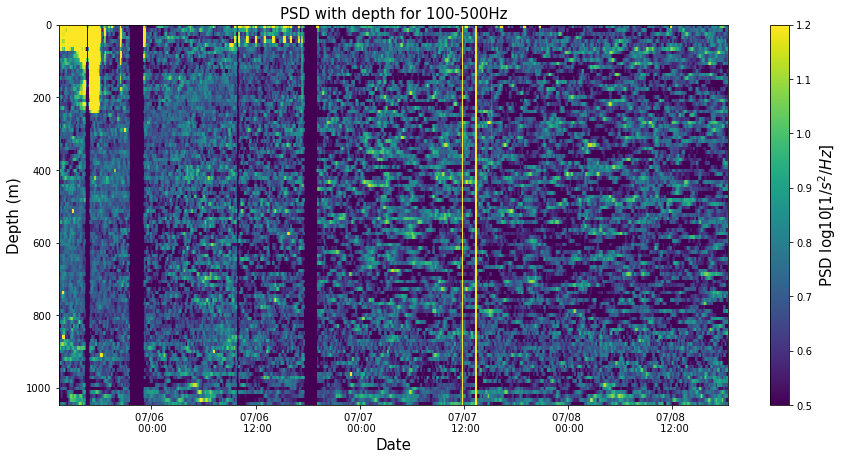

In [298]:
b = 5
fig,ax = plt.subplots(figsize=(15,7))
s_plot = ax.pcolormesh(datetimes,(channels-331)*spacing,np.log10(spatial_spec[:,:,b]),vmin=0.5,vmax=1.2)
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d \n %H:%M'))
cbar = plt.colorbar(s_plot)
ax.set_xlabel("Date",size=15)
ax.set_ylabel("Depth (m)",size=15)
ax.set_title("PSD with depth for "+str(freq_bins[b])+"-"+str(freq_bins[b+1])+"Hz",size=15)
cbar.set_label(r"PSD log10$\left[1/s^2/Hz\right]$",size=15)
c_ticks = cbar.get_ticks()
c_ticks_log = ["$10^"+"{"+str(c_tick)+"}$" for c_tick in c_ticks]
#cbar.ax.set_yticklabels(c_ticks_log) 
plt.savefig(path+"spatial_spectrogram_"+str(freq_bins[b])+"-"+str(freq_bins[b+1])+"Hz.png")
plt.savefig("/home/solinger/spectrograms/spatial_spectrogram_"+str(freq_bins[b])+"-"+str(freq_bins[b+1])+"Hz.png")